In [1]:
import sys
module_path = os.path.abspath('..')
sys.path.append(module_path)
from lc.measurements import CurveMeasurements
from lc.curve import LearningCurveEstimator
from omegaconf import OmegaConf

Load error measurements using `CurveMeasurements`. See `notebooks/measurements.ipynb` for more about reading error measurements.  

In [2]:
curvems = CurveMeasurements()
curvems.load_from_json('../data/no_pretr_ft.json')
print(curvems)

--
num_train_samples: 25
test_errors: [74.04, 74.48, 74.07, 74.4, 75.95, 74.97, 74.02, 75.8, 74.6, 74.27]
num_ms: 10
--
num_train_samples: 50
test_errors: [57.59, 58.45, 58.13, 58.44, 59.46, 58.14, 58.71, 58.22]
num_ms: 8
--
num_train_samples: 100
test_errors: [45.01, 43.64, 45.06, 44.63]
num_ms: 4
--
num_train_samples: 200
test_errors: [35.36, 35.2]
num_ms: 2
--
num_train_samples: 400
test_errors: [27.92]
num_ms: 1
--



Load default config. Modify `config.yaml` directly or update parameters once loaded. 

In [3]:
cfg = OmegaConf.load('../lc/config.yaml')
print('-'*20)
print('Default config')
print('-'*20)
print(OmegaConf.to_yaml(cfg))

cfg.gamma_search = False
print('-'*20)
print('Modified config')
print('-'*20)
print(OmegaConf.to_yaml(cfg))

--------------------
Default config
--------------------
gamma: -0.5
gamma_search: true
gamma_range:
- -1.0
- 0
search_reg_coeff: 5
normalize_objective: false
variance_type: smooth
use_weights: true
ddof: 1
v_0: 0.02
min_n: 20
'N': 400
num_interp_pts: 100
marker_size: 20

--------------------
Modified config
--------------------
gamma: -0.5
gamma_search: false
gamma_range:
- -1.0
- 0
search_reg_coeff: 5
normalize_objective: false
variance_type: smooth
use_weights: true
ddof: 1
v_0: 0.02
min_n: 20
'N': 400
num_interp_pts: 100
marker_size: 20



In [4]:
curve_estimator = LearningCurveEstimator(cfg)
curve, objective = curve_estimator.estimate(curvems)
print('Quality of the fit:',objective)
curve.print_summary(cfg.N)

Quality of the fit: 16.561
------------------------------
Learning curve summary
------------------------------
error_400: 28.2575
beta_400: 16.0257
gamma: -0.5
alpha: 12.2318
eta: 320.5148


Searching for gamma leads to better fit. To enable gamma search set `gamma_search` to `True` (default). When gamma search is disabled, `curve_estimator.estimate()` uses `cfg.gamma` to estimate the curve. 

In [5]:
cfg.gamma_search = True
curve, objective = curve_estimator.estimate(curvems)
print('Quality of the fit:',objective)
curve.print_summary(cfg.N)

Quality of the fit: 6.2808
------------------------------
Learning curve summary
------------------------------
error_400: 27.9133
beta_400: 18.2284
gamma: -0.41
alpha: 5.6835
eta: 259.2864


Use `curve_estimator.plot()` to visualizes the learning curve and the error measurements.  

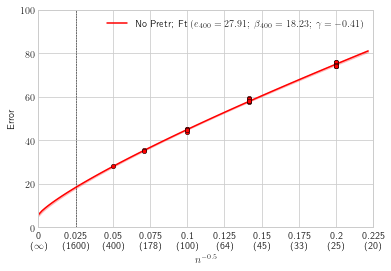

In [6]:
curve_estimator.plot(curve,curvems,label='No Pretr; Ft')

You may also want to visualize the variance estimates. We recommend using the smoothed variance estimate but you can switch to using sample variance for curve estimation by setting `cfg.variance_type='sample'`. See `notebooks/variance.ipynb` for details on smooth variance estimation. 

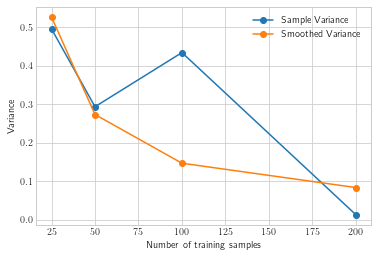

In [7]:
curve_estimator.err_mean_var_estimator.visualize(curvems)

Plot multiple curves for easy comparison.

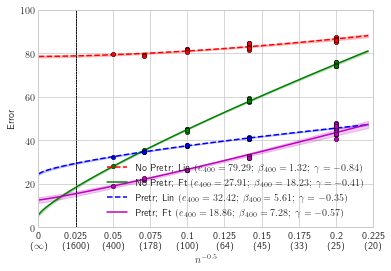

In [8]:
plot_metadata = [
    ['../data/no_pretr_linear.json','No Pretr; Lin','r','--'],
    ['../data/no_pretr_ft.json','No Pretr; Ft','g','-'],
    ['../data/pretr_linear.json','Pretr; Lin','b','--'],
    ['../data/pretr_ft.json','Pretr; Ft','m','-']
]
for (json_path,label,color,linestyle) in plot_metadata:
    curvems.load_from_json(json_path)
    curve, _ = curve_estimator.estimate(curvems)
    curve_estimator.plot(curve,curvems,label,color,linestyle)

Technically, it is possible to use just 2 training set sizes to estimate the learning curve but the results maybe susceptible to high variance. For instance, here we estimate the learning curve using only measurements on training set sizes of 400 and 200.  

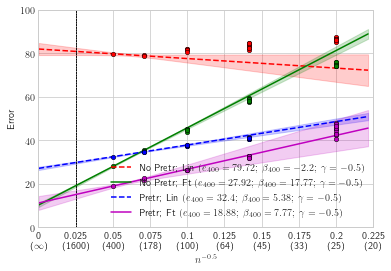

In [9]:
import copy
for (json_path,label,color,linestyle) in plot_metadata:
    curvems.load_from_json(json_path)
    curvems_filtered = copy.deepcopy(curvems)
    curvems_filtered.curvems = [errms for errms in curvems if errms.num_train_samples in [400,200]]
    curve, _ = curve_estimator.estimate(curvems_filtered)
    curve_estimator.plot(curve,curvems,label,color,linestyle)

However, results improve considerably when using 3 training set sizes. Below, we estimate learning curve using measurements on training sets of sizes 400, 200, and 100. 

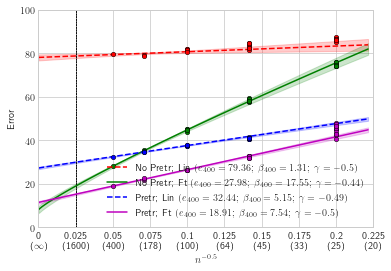

In [10]:
for (json_path,label,color,linestyle) in plot_metadata:
    curvems.load_from_json(json_path)
    curvems_filtered = copy.deepcopy(curvems)
    curvems_filtered.curvems = [errms for errms in curvems if errms.num_train_samples in [400,200,100]]
    curve, _ = curve_estimator.estimate(curvems_filtered)
    curve_estimator.plot(curve,curvems,label,color,linestyle)

It may be possible to use much smaller training set sizes to compute learning curves as shown below. Note that the errors predicted by the curve at 200 and 400 training set sizes, which were not used to estimate the curve, are reasonably accurate.   

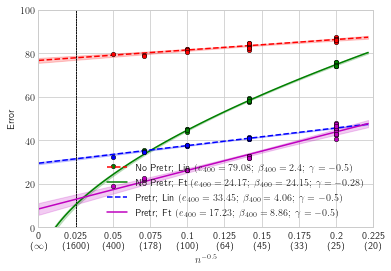

In [11]:
for (json_path,label,color,linestyle) in plot_metadata:
    curvems.load_from_json(json_path)
    curvems_filtered = copy.deepcopy(curvems)
    curvems_filtered.curvems = [errms for errms in curvems if errms.num_train_samples in [100,50,25]]
    curve, _ = curve_estimator.estimate(curvems_filtered)
    curve_estimator.plot(curve,curvems,label,color,linestyle)